## Лабораторая №4. Восстановление функции распренделения вероятности
   - Реализовать метод восстановления плотности вероятности двумя способами:
    - EM-алгоритм
    - Ядерное сглаживание
   - Применить данные методы на любом наборе случайных точек
   - Реализовать метод Метрополиса-Гастингса и Гибсона для несимметричного распределения. Применить два метода на основе той функции плотности, которая была восстановлена в прошлом пункте, тем самым получив изначальные точки.
   - В методе М-Г нарисовать картинку блуждания в случае 3D-функции плотности (на доп баллы)
   - Сравнить красный и синий набор точек (сгенерированые и исходные) (с помощью Расстояния Кульбака-Лейблера)

## Методы восстановления плотности вероятности:

Реализуем EM-алгоритм (смесь Гауссовых распределений):

In [181]:
import numpy as np
from sklearn.mixture import GaussianMixture


samples_count = 1000
X = np.concatenate([np.random.normal(loc=-5, scale=1, size=samples_count//2),
                    np.random.normal(loc=5, scale=0.5, size=samples_count//2)])

gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X.reshape(-1, 1))

x = np.linspace(X.min() - 1, X.max() + 1, 1000)
gmm_density = np.exp(gmm.score_samples(x.reshape(-1, 1)))

Реализуем метод ядерного склаживания:

In [182]:
from sklearn.neighbors import KernelDensity


kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X.reshape(-1, 1))
kde_density = np.exp(kde.score_samples(x.reshape(-1, 1)))

Визуализируем полученные результаты:

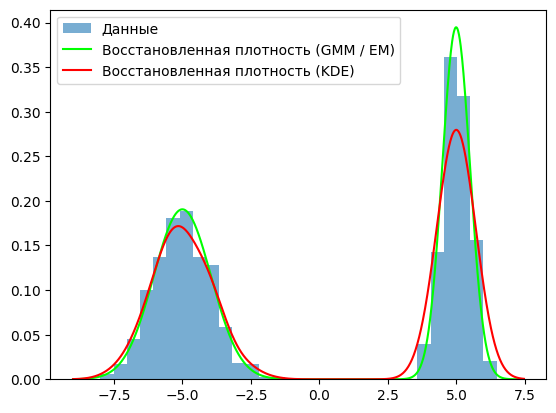

In [183]:
import matplotlib.pyplot as plt


plt.hist(X, bins=30, density=True, alpha=0.6, label='Данные')
plt.plot(x, gmm_density, color='lime', label='Восстановленная плотность (GMM / EM)')
plt.plot(x, kde_density, color='r', label='Восстановленная плотность (KDE)')
plt.legend()
plt.show()

## Методы Метрополиса-Гастингса и Гибсона:

Реализуем метод Метрополиса-Гастингса:

In [184]:
def metropolis_hastings(target_density, initial_value, n_samples, proposal_std):
    samples = []
    current = initial_value
    for _ in range(n_samples):
        proposal = np.random.normal(current, proposal_std)
        acceptance_ratio = min(1, target_density(proposal) / target_density(current))
        if np.random.rand() < acceptance_ratio:
            current = proposal
        samples.append(current)
    return np.array(samples)

Реализуем метод Гибсона:

In [185]:
def gibbs_sampling(initial_values, conditional_distributions, n_samples):
    samples = [initial_values]
    current = np.array(initial_values)
    for _ in range(n_samples - 1):
        for i, conditional in enumerate(conditional_distributions):
            current[i] = conditional(*current[:i], *current[i + 1:])
        samples.append(current.copy())
    return np.array(samples)

Применение полученных методов к результату EM-алгоритма:

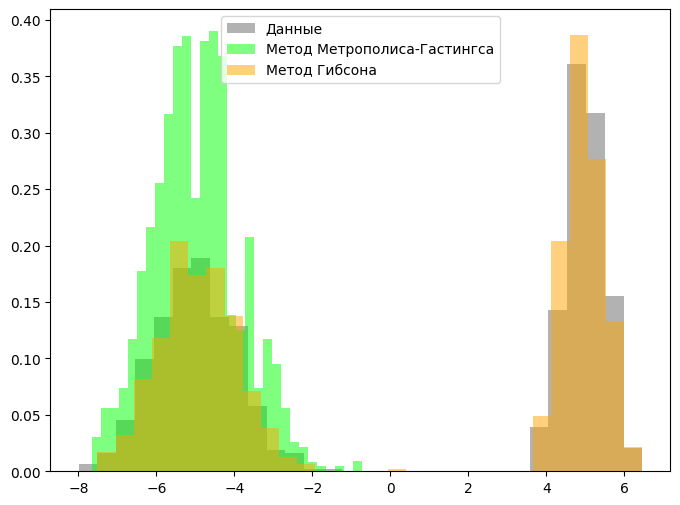

In [186]:
def gmm_target_density(x):
    return np.exp(gmm.score_samples(np.array([[x]])))


mh_samples = metropolis_hastings(gmm_target_density, X.mean(), samples_count, proposal_std=1.0)
gibbs_samples = gibbs_sampling([X.mean()], [lambda: np.random.choice(X)], samples_count)

plt.figure(figsize=(8, 6))
plt.hist(X, bins=30, density=True, alpha=0.6, label='Данные', color='grey')
plt.hist(mh_samples, bins=30, density=True, alpha=0.5, label='Метод Метрополиса-Гастингса', color='lime')
plt.hist(gibbs_samples, bins=30, density=True, alpha=0.5, label='Метод Гибсона', color='orange')
plt.legend()
plt.show()

Применение полученных методов к результату метода ядерного склаживания:

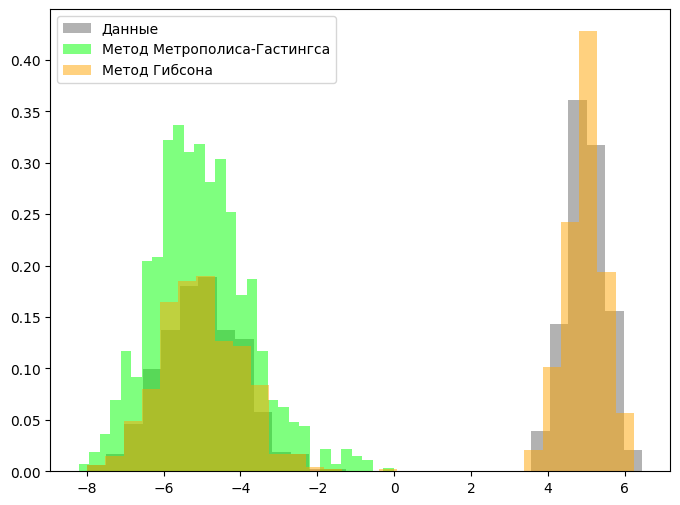

In [187]:
def kde_target_density(x):
    return np.exp(kde.score_samples(np.array([[x]])))

mh_samples = metropolis_hastings(kde_target_density, X.mean(), samples_count, proposal_std=1.0)
gibbs_samples = gibbs_sampling([X.mean()], [lambda: np.random.choice(X)], samples_count)

plt.figure(figsize=(8, 6))
plt.hist(X, bins=30, density=True, alpha=0.6, label='Данные', color='grey')
plt.hist(mh_samples, bins=30, density=True, alpha=0.5, label='Метод Метрополиса-Гастингса', color='lime')
plt.hist(gibbs_samples, bins=30, density=True, alpha=0.5, label='Метод Гибсона', color='orange')
plt.legend()
plt.show()

## Блуждания в методе Метрополиса-Гастингса для 3D-функции плотности:

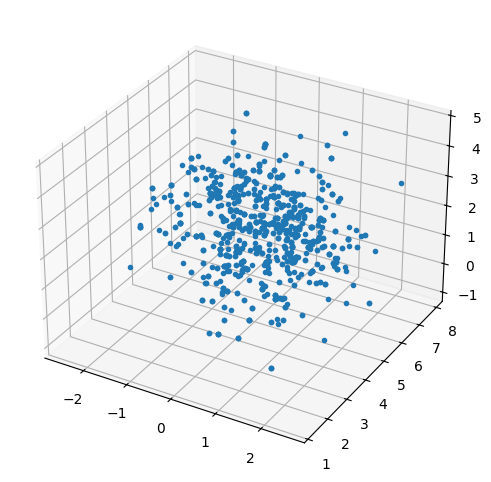

In [188]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm


x = np.linspace(-3, 8, 1000)[:, np.newaxis]
p_3d = lambda x: norm.pdf(x[0], loc=0, scale=1) * norm.pdf(x[1], loc=5, scale=1) * norm.pdf(x[2], loc=2, scale=1)
proposal_3d = lambda x: x + np.random.normal(0, 1, size=3)
samples_3d = metropolis_hastings(p_3d, [0, 0, 0], samples_count, proposal_std=1.0)

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection='3d'))
plt.plot(samples_3d[:, 0], samples_3d[:, 1], samples_3d[:, 2], 'o', markersize=3)
plt.show()

## КЛ-дивергенция:

Сравним сгенерированые и исходные точки с помощью расстояния Кульбака-Лейблера:

In [192]:
from scipy.stats import entropy

hist_original, bins_original = np.histogram(X, bins=30, density=True)
hist_mh, _ = np.histogram(samples_mh, bins=bins_original, density=True)
hist_gibbs, _ = np.histogram(samples_gibbs, bins=bins_original, density=True)

print(f"КЛ-дивергенция для метода Метрополиса-Гастингса: {entropy(hist_original + 1e-9, hist_mh + 1e-9)}")
print(f"КЛ-дивергенция для метода Гибсона: {entropy(hist_original + 1e-9, hist_gibbs + 1e-9)}")

КЛ-дивергенция для метода Метрополиса-Гастингса: 9.819853188447823
КЛ-дивергенция для метода Гибсона: 1.2130091937070242
